# Finding surveillance planes using random forests

**The stories:**

- https://www.buzzfeednews.com/article/peteraldhous/spies-in-the-skies
- https://www.buzzfeednews.com/article/peteraldhous/hidden-spy-planes
    
This story, done by Peter Aldhous at Buzzfeed News, involved training a machine learning algorithm to recognize government surveillance planes based on what their flight patterns look like.

**Datasets**

* **feds.csv:** Transponder codes of planes operated by the federal government
* **planes_features.csv:** various features describing each plane's flight patterns
* **train.csv:** a labeled dataset of transponder codes and whether each plane is a surveillance plane or not
    - The `label` column was originally `class`, but I renamed it because pandas freaks out a bit with a column named `class`
    - This was created by Buzzfeed `feds.csv`
* **data dictionary:** You can find the data dictionary published with their analysis [here](https://buzzfeednews.github.io/2016-04-federal-surveillance-planes/analysis.html)
* **a few other files**

## What's the goal?

The FBI and Department of Homeland Security operate many planes that are not directly labeled as belonging to the government. If we can uncover these planes, we have a better idea of the surveillance activities they are undertaking.

## Imports

Let's also set a large number of maximum columns.

In [9]:
import pandas as pd

pd.set_option("display.max_columns", 100)

# Read in our data

Almost all classification problems start with a set of labeled features. In this case, the features are in one CSV file and the labels are in another.

**Read in both `planes_features.csv` and `train.csv` and merge them on `adshex`, the transpoder code.**

In [10]:
planes = pd.read_csv('planes_features.csv')
planes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19799 entries, 0 to 19798
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   adshex        19799 non-null  object 
 1   duration1     19799 non-null  float64
 2   duration2     19799 non-null  float64
 3   duration3     19799 non-null  float64
 4   duration4     19799 non-null  float64
 5   duration5     19799 non-null  float64
 6   boxes1        19799 non-null  float64
 7   boxes2        19799 non-null  float64
 8   boxes3        19799 non-null  float64
 9   boxes4        19799 non-null  float64
 10  boxes5        19799 non-null  float64
 11  speed1        19799 non-null  float64
 12  speed2        19799 non-null  float64
 13  speed3        19799 non-null  float64
 14  speed4        19799 non-null  float64
 15  speed5        19799 non-null  float64
 16  altitude1     19799 non-null  float64
 17  altitude2     19799 non-null  float64
 18  altitude3     19799 non-nu

In [11]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   adshex  597 non-null    object
 1   label   597 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [12]:
pd.merge(planes,train,on='adshex')

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,label
0,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP,other
1,A00220,0.000000,0.254902,0.176471,0.313725,0.254902,0.058824,0.372549,0.294118,0.215686,0.058824,0.052650,0.191676,0.419769,0.329805,0.006099,0.244327,0.235985,0.123329,0.307023,0.089335,0.034801,0.038389,0.263342,0.375998,0.132030,0.120011,0.008611,0.006906,51,0,11149,RV10,other
2,A0041E,0.142857,0.285714,0.000000,0.571429,0.000000,0.285714,0.142857,0.285714,0.285714,0.000000,0.009050,0.135747,0.426848,0.322775,0.105581,0.179487,0.067873,0.352941,0.399698,0.000000,0.010558,0.009050,0.108597,0.657617,0.090498,0.078431,0.010558,0.019608,7,0,663,SR22,other
3,A00889,0.000000,0.120000,0.200000,0.080000,0.600000,0.000000,0.200000,0.120000,0.280000,0.400000,0.005785,0.059895,0.187936,0.628297,0.118087,0.058448,0.122426,0.068402,0.582865,0.167858,0.002978,0.009784,0.078782,0.814361,0.065339,0.023907,0.001276,0.001702,25,7760,11754,SR22,other
4,A008BE,0.000000,0.300000,0.200000,0.200000,0.300000,0.000000,0.300000,0.200000,0.300000,0.200000,0.183099,0.380282,0.152113,0.218310,0.066197,0.108451,0.029577,0.314085,0.102817,0.445070,0.021127,0.018310,0.250704,0.436620,0.092958,0.145070,0.001408,0.009859,10,1200,710,PA24,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,ADD003,0.000000,0.244898,0.081633,0.122449,0.551020,0.000000,0.020408,0.326531,0.224490,0.428571,0.003976,0.024773,0.059741,0.119890,0.791620,0.142930,0.153227,0.133347,0.132429,0.438067,0.008666,0.022632,0.146396,0.625548,0.096850,0.082271,0.005097,0.002753,49,1200,9809,BE20,other
593,ADD1C7,0.162791,0.046512,0.209302,0.279070,0.302326,0.162791,0.093023,0.139535,0.302326,0.302326,0.023086,0.172539,0.213852,0.417983,0.172539,0.024301,0.069259,0.063183,0.251519,0.591738,0.054678,0.046173,0.103281,0.521264,0.025516,0.125152,0.012151,0.040097,43,0,823,BE58,other
594,ADEDB8,0.104167,0.166667,0.291667,0.145833,0.291667,0.104167,0.145833,0.187500,0.250000,0.312500,0.096814,0.180062,0.268243,0.249332,0.205550,0.038232,0.095786,0.155807,0.233094,0.477081,0.028160,0.042343,0.239877,0.356629,0.085509,0.203700,0.015827,0.013155,48,1340,4865,PA46,other
595,ADEE39,0.348485,0.121212,0.136364,0.227273,0.166667,0.424242,0.257576,0.136364,0.090909,0.090909,0.485031,0.481651,0.013520,0.004829,0.014969,0.055529,0.187108,0.270159,0.469821,0.017383,0.039112,0.032593,0.276919,0.294544,0.106229,0.193143,0.011830,0.022211,66,0,4142,C172,other


### No wait, merge them again!

We have **features** for about 20,000 planes and **labels** for about 600 planes. This is because we don't know whether many of the planes are surveillance planes or not. When you merge, it only keeps rows you have **both features and labels for**.

We want to keep those in the dataframe so we can play detective with them later, and try to find surveillance planes using the features. When you merge, you should use `how='left'` or `how='right'` to keep unmatched columns from the left (or right) dataframe.

Save this merged dataframe as `df`.

In [13]:
df = pd.merge(planes,train,on='adshex',how='left')

Confirm you have 19,799 rows and 34 columns.

In [14]:
df.shape

(19799, 34)

# Cleaning up our data

## Number-izing our labels

Each row is a plane, and it's marked as either a surveillance plane or not. How many do we have in each category?

In [15]:
df['label'].value_counts()

other      500
surveil     97
Name: label, dtype: int64

How do you feel about that split? Is it balanced enough?

**Let's this column for machine learning.** `"surveil"` and `"other"` won't work with sklearn because they're strings, not numbers. Adjust the `label` column to be something that we can use with sklearn.

In [16]:
df.label.replace({
    'other': 0,
    'surveil': 1
}).value_counts()

0.0    500
1.0     97
Name: label, dtype: int64

In [17]:
df['label_code'] = df.label.replace({
    'other': 0,
    'surveil': 1
})

## Categorical variables

Do we have any variables that count as categories? Yes, we do, `type` of plane! **How many different categories does it have?**

In [18]:
len(df['type'].unique())

455

In [19]:
df['type'].unique()

array(['GRND', 'TBM7', 'SHIP', 'PA46', 'C56X', 'C82S', 'PC12', 'R66',
       'DA42', 'BE36', 'unknown', 'BE20', 'BE9T', 'B407', 'SR22', 'A139',
       'BE9L', 'B429', 'B350', 'TBM8', 'EPIC', 'GLF4', 'BE35', 'ALIG',
       'RV10', 'PAY1', 'C210', 'C172', 'C310', 'AEST', 'C182', 'RV6',
       'C208', 'BE55', 'B36T', 'AS55', 'BE58', 'C55B', 'BE60', 'C421',
       'MU2', 'PA31', 'ZZZZ', 'C340', 'BE33', 'C501', 'CRER', 'E50P',
       'BE10', 'B190', 'PA27', 'LNC2', 'LNC4', 'P210', 'M20P', 'C402',
       'SR20', 'PA24', 'C240', 'PA34', 'RV3', 'E45X', 'M20T', 'COL3',
       'AC11', 'C441', 'H500', 'LJ25', 'C185', 'COL4', 'P28B', 'T206',
       'C404', 'P28A', 'P32R', 'T210', 'BE80', 'AS50', 'WW24', 'B06',
       'GLF2', 'EC20', 'PA32', 'F2TH', 'P28R', 'H25B', 'C680', 'P180',
       'EA50', 'S22T', 'GLID', 'BE99', 'C180', 'P46T', 'LA4', 'DHC2',
       'DA40', 'KODI', 'PAY2', 'RV9', 'R44', 'C25A', 'RV7', 'A109',
       'SBR1', 'T33', 'C414', 'RV8', 'PA30', 'EVOT', 'EC30', 'SWAK',
       'EFOX',

These are **text**, not numbers, so we can't automatically use them in our classifier. But it's a little different than when we were working with actual documents - running this across a TF-IDF vetorizer shoudln't seem to make much sense.

Instead, we'll just **make each plane type a number.** For example, `unknown` might be `0` and `C172` might be `1` and `SR22` might be `2`. 

If you want to convert a list of categories into numbers, an easy way is to use the `Categorical` data type.

In [20]:
df.type = df.type.astype('category')
df.type.head()

0    GRND
1    TBM7
2    SHIP
3    PA46
4    C56X
Name: type, dtype: category
Categories (455, object): ['208', 'A109', 'A119', 'A139', ..., 'WW24', 'XL2', 'ZZZZ', 'unknown']

It looks like a normal bunch of strings, but pandas is secretly using a number for each one! You can find the number with `.cat.codes`.

**We can use `df.type.cat.codes` to make a new columns called `type_code`.** 

In [21]:
df.type.cat.codes

0        248
1        431
2        399
3        350
4        126
        ... 
19794    454
19795    454
19796    454
19797    454
19798    454
Length: 19799, dtype: int16

In [22]:
df['type_code'] = df.type.cat.codes

df[['type', 'type_code']].head(10)

,type,type_code
0,GRND,248
1,TBM7,431
2,SHIP,399
3,PA46,350
4,C56X,126
5,C82S,133
6,PC12,356
7,R66,369
8,DA42,164
9,BE36,54


We'll use `type_code` for machine learning since sklearn needs a number, and `type` for reading since we like text.

# Building our classifier

To build a classifier, we need an `X` and a `y`. If we're working with text, we usually just use the `words_df` for the features and whatever our label column is for the `y`.

```python
X = words_df
y = df.label_column
```

This time it's going to be a little bit different, and take a few more steps!

First, since we have **labeled** and **unlabeled data** in the same dataframe, we need to get rid of all of the rows that don't have a `label`. Save this labeled dataset as `train_df`.

In [23]:
train_df = df.dropna(subset=['label_code'])

Confirm your `train_df` has 597 rows. **And while we're at it, let's look at the first five rows.**

In [24]:
train_df.shape

(597, 36)

In [25]:
train_df.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,label,label_code,type_code
2,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP,other,0.0,399
29,A00220,0.000000,0.254902,0.176471,0.313725,0.254902,0.058824,0.372549,0.294118,0.215686,0.058824,0.052650,0.191676,0.419769,0.329805,0.006099,0.244327,0.235985,0.123329,0.307023,0.089335,0.034801,0.038389,0.263342,0.375998,0.132030,0.120011,0.008611,0.006906,51,0,11149,RV10,other,0.0,374
55,A0041E,0.142857,0.285714,0.000000,0.571429,0.000000,0.285714,0.142857,0.285714,0.285714,0.000000,0.009050,0.135747,0.426848,0.322775,0.105581,0.179487,0.067873,0.352941,0.399698,0.000000,0.010558,0.009050,0.108597,0.657617,0.090498,0.078431,0.010558,0.019608,7,0,663,SR22,other,0.0,406
122,A00889,0.000000,0.120000,0.200000,0.080000,0.600000,0.000000,0.200000,0.120000,0.280000,0.400000,0.005785,0.059895,0.187936,0.628297,0.118087,0.058448,0.122426,0.068402,0.582865,0.167858,0.002978,0.009784,0.078782,0.814361,0.065339,0.023907,0.001276,0.001702,25,7760,11754,SR22,other,0.0,406
124,A008BE,0.000000,0.300000,0.200000,0.200000,0.300000,0.000000,0.300000,0.200000,0.300000,0.200000,0.183099,0.380282,0.152113,0.218310,0.066197,0.108451,0.029577,0.314085,0.102817,0.445070,0.021127,0.018310,0.250704,0.436620,0.092958,0.145070,0.001408,0.009859,10,1200,710,PA24,other,0.0,342


Before we make our `X` - our set of features that predicts the label - note that we also have a few extra columns that we aren't using to train our classifier:

1. The `adshex` transponder code
2. The text version of the plane type

We'll need to get rid of these in a second!

### Create your `X` and `y`.

Creating your `X` and `y` for non-text-analysis projects looks different than for text-based analysis.

In these non-text situations, we usually have a single dataframe that we want certain columns out of.

* `X` are the columns that we use to make the predictions, our features. Usually we want every single column of data, which means we do `X = train_df.drop(columns=['label_column'])`. This makes sure we aren't including the label in our features.
* `y` is the column that is the label that we are predicting

In this case, though, we want to get rid of more than just the label column. Adjust the code below to also remove the transponder code and plane type.

In [26]:
X = train_df.drop(columns=['label','label_code','type','adshex'])

y = train_df.label_code

Triple-check that `X` is a list of numeric features and and `y` is a numeric label.

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 2 to 19672
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   duration1     597 non-null    float64
 1   duration2     597 non-null    float64
 2   duration3     597 non-null    float64
 3   duration4     597 non-null    float64
 4   duration5     597 non-null    float64
 5   boxes1        597 non-null    float64
 6   boxes2        597 non-null    float64
 7   boxes3        597 non-null    float64
 8   boxes4        597 non-null    float64
 9   boxes5        597 non-null    float64
 10  speed1        597 non-null    float64
 11  speed2        597 non-null    float64
 12  speed3        597 non-null    float64
 13  speed4        597 non-null    float64
 14  speed5        597 non-null    float64
 15  altitude1     597 non-null    float64
 16  altitude2     597 non-null    float64
 17  altitude3     597 non-null    float64
 18  altitude4     597 non-null  

In [28]:
y

2        0.0
29       0.0
55       0.0
122      0.0
124      0.0
        ... 
19500    0.0
19518    0.0
19626    0.0
19632    0.0
19672    0.0
Name: label_code, Length: 597, dtype: float64

### Split into train and test datasets

We could be nice and lazy and use all our data for training, but it just isn't right! Taking a test using the exact same questions you studied is just cheating. Split your data into test and train.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Classify using a logistic classifier

## Train your classifier

Build a `LogisticRegression` and fit it to your data, making sure you're training using only `X_train` and `y_train`.

You can build a Logistic Regression classifier like this:

```python
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1e9, solver='lbfgs', max_iter=4000)
```

In [30]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1e9, solver='lbfgs', max_iter=4000)

In [31]:
clf.fit(X_train,y_train)

LogisticRegression(C=1000000000.0, max_iter=4000)

## Explaining our classifier

Let's use eli5 to explain our classifier. What are the important features for detecting a surveillance plane?

```python
import eli5

feature_names = list(X.columns)

eli5.show_weights(clf, feature_names=feature_names)
```

Use the code above.

In [32]:
import eli5

feature_names = list(X.columns)

eli5.show_weights(clf, feature_names=feature_names)

# The classifier also introduce <BIAS> feature which is expected average score output by the model, 
# based on the distribution of the training set. 
# https://towardsdatascience.com/machine-learning-explainability-introduction-via-eli5-99c767f017e2

## How well does our classifier perform?

Let's take a look at the confusion matrix to see how well this classifier finds surveillance planes. Make sure you're using `y_test` and `X_test`, not the full dataset.

In [33]:
train_df.label_code.unique()

array([0., 1.])

In [34]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['other', 'surveil'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)
#.div(matrix.sum(axis=1),axis=0)

,Predicted other,Predicted surveil
Is other,123,6
Is surveil,8,13


In [35]:
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1),axis=0)

,Predicted other,Predicted surveil
Is other,0.953488,0.046512
Is surveil,0.380952,0.619048


# Classify using a decision tree

Now we'll use a decision tree. This is how you make one:

```python
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
```

If we use `max_depth=` to limit the depth of the tree, it will help us visualize it. For example, `max_depth=5` will only allow the tree to make five decisions.

Make a decision tree and fit it to your data. Use a `max_depth=` of something between 2 to 5.

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
clf_tree = DecisionTreeClassifier(max_depth=5)

In [38]:
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

## What are the important features?

We'll use slighyl different code for a decision tree, as it likes to draw big pictures if we don't stop it. The code looks like this:

```python
import eli5

feature_names=list(X.columns)
eli5.show_weights(clf, feature_names=feature_names, show=['description', 'feature_importances'])
```

In [70]:
import eli5

feature_names=list(X.columns)
eli5.show_weights(clf, feature_names=feature_names, show=['description', 'feature_importances'])

### Understanding the output

We'll do this in class.

## How well does the tree perform?

Display another confusion matrix with your new classifier.

In [40]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf_tree.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['other', 'surveil'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)
#.div(matrix.sum(axis=1),axis=0)

,Predicted other,Predicted surveil
Is other,123,6
Is surveil,2,19


In [41]:
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1),axis=0)

,Predicted other,Predicted surveil
Is other,0.953488,0.046512
Is surveil,0.095238,0.904762


## Visualize the tree

You can use `eli5` to visualize the decision tree itself! It usually takes up too much space, but since it's a special occasion we'll let it go. You... might need to install something for this to work? I'm not 100% sure, though.

In [42]:
feature_names=list(X.columns)

label_names = ['not surveillance', 'surveillance']
eli5.show_weights(clf, feature_names=feature_names, target_names=label_names, show=['decision_tree'])

In [43]:
# pip install graphviz

If you'd like your graph to have colors colors, or to not use eli5, you can do it the old-fashioned way. You might need to `brew install graphviz` and `pip install graphviz`. Windows users will need to download and install from [the graphviz website](https://graphviz.org/download/), and potentially add graphviz to their path.

```python
from sklearn import tree
import graphviz

label_names = ['not surveillance', 'surveillance']
feature_names = X.columns

dot_data = tree.export_graphviz(clf,
                    feature_names=feature_names,  
                    filled=True,
                    class_names=label_names)  
graph = graphviz.Source(dot_data)  
graph
```

* **Tip:** You'll probably need to scroll sideways a bit

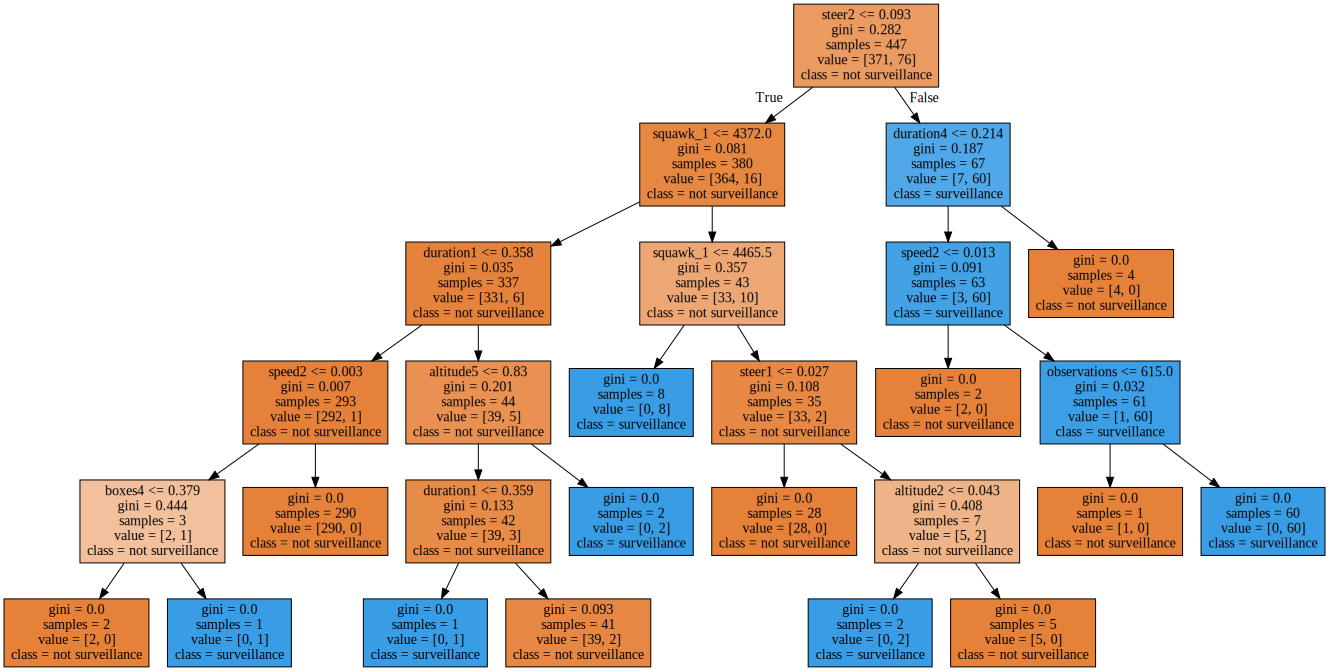

In [44]:
from sklearn import tree
import graphviz

label_names = ['not surveillance', 'surveillance']
feature_names = X.columns

dot_data = tree.export_graphviz(clf_tree,
                    feature_names=feature_names,  
                    filled=True,
                    class_names=label_names)  
graph = graphviz.Source(dot_data)  
graph

# One more classifier: Random forest

## Build and train your classifier

We can build a random forest classifier like this:

```python
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
```

But you're in charge of fitting it to your training data!

* **Tip:** You can also set `max_depth` here if you want.
* **Tip:** Increase `n_estimators` to 100 to make a better classifier.

In [45]:
from sklearn.ensemble import RandomForestClassifier
clf_random = RandomForestClassifier(n_estimators=100)

## What are the important features?

Use eli5 to obtain the feature importances. The best method for a random forest is below.

```python
feature_names = list(X.columns)
eli5.show_weights(clf, feature_names=feature_names, show=['description', 'feature_importances'])
```

In [46]:
clf_random.fit(X_train,y_train)
feature_names = list(X.columns)
eli5.show_weights(clf_random, feature_names=feature_names, show=['description', 'feature_importances'])

Weight,Feature
0.2239 ± 0.5303,steer2
0.1318 ± 0.3889,steer1
0.0994 ± 0.3255,squawk_1
0.0968 ± 0.3254,steer5
0.0422 ± 0.1842,steer4
0.0364 ± 0.1411,steer6
0.0296 ± 0.1313,altitude3
0.0271 ± 0.0898,duration4
0.0259 ± 0.1023,speed1
0.0202 ± 0.0919,boxes5


### Understanding the output

Random forests are a collection of decision trees. We'll talk about how to understand the feature importance in class!

## How well does it perform?

Use a confusion matrix.

In [47]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf_random.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['other', 'surveil'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)
#.div(matrix.sum(axis=1),axis=0)

,Predicted other,Predicted surveil
Is other,128,1
Is surveil,4,17


In [48]:
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1),axis=0)

,Predicted other,Predicted surveil
Is other,0.992248,0.007752
Is surveil,0.190476,0.809524


## Which model are you most confident in?

In [49]:
# Decision trees

# Actually finding spy planes

Now let's try ot actually find our spy planes

## Retrain our model

When we did test/train split, we trained our model with only a subset of our data, so we could test with the rest. Now that we're working in the "real world" we want to re-train it using not just `_train` and `_test` data, but instead **everything we have labels for.**

That's the whole `X` and `y`.

In [50]:
clf_tree.fit(X,y)

DecisionTreeClassifier(max_depth=5)

## Filter for planes we want to predict

We have a dataframe of features that includes three types of planes:

* Those that are labeled as surveillance planes
* Those that are labeled as not surveillance
* Those that aren't labeled

Which do we want to predictions for? **Filter to create new dataframe that's just unlabeled planes.** We'll call it `unknown_df`.

In [51]:
unknown_df = df[df['label_code'].isna()]

How many planes do you have in that list? **Confirm it's about 19,200.**

In [52]:
unknown_df.shape

(19202, 36)

## Predicting 

Build your `X_unknown` - remember you need to drop a few columns! We only want **numeric features** here.

In [53]:
X_unknown = unknown_df.drop(columns=['label','label_code','type','adshex'])
# y = train_df.label

Now use that to make a prediction for each plane, and **assign the prediction into the `predicted` column of `unknown_df`**.

* **Tip:** Scroll up to see where you created your features for training, it's similar
* **Tip:** pandas will yell at us about setting values on copies of a slice but it's fine

In [54]:
unknown_df['predicted'] = clf_tree.predict(X_unknown)

unknown_df

<ipython-input-54-231614d468df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df['predicted'] = clf_tree.predict(X_unknown)


,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,label,label_code,type_code,predicted
0,A,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND,NaN,NaN,248,0.0
1,A00000,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7,NaN,NaN,431,0.0
3,A00008,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46,NaN,NaN,350,0.0
4,A0001E,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X,NaN,NaN,126,0.0
5,A0002B,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.767405,0.191456,0.023734,0.017405,0.000000,0.150316,0.113924,0.178797,0.534810,0.022152,0.001582,0.009494,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6,2356,632,C82S,NaN,NaN,133,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19794,ADFFFA,0.090909,0.454545,0.000000,0.454545,0.000000,0.000000,0.272727,0.181818,0.363636,0.181818,0.012195,0.008711,0.017422,0.099303,0.862369,0.003484,0.137631,0.203833,0.071429,0.583624,0.054007,0.073171,0.214286,0.322300,0.078397,0.200348,0.008711,0.024390,11,5154,574,unknown,NaN,NaN,454,1.0
19795,ADFFFC,0.352941,0.323529,0.176471,0.117647,0.029412,0.235294,0.176471,0.264706,0.117647,0.205882,0.020158,0.005259,0.025416,0.095530,0.853637,0.025416,0.122699,0.131464,0.149869,0.570552,0.025416,0.028046,0.232252,0.359334,0.070990,0.199825,0.021911,0.035057,34,0,1141,unknown,NaN,NaN,454,0.0
19796,ADFFFF,0.192308,0.423077,0.230769,0.115385,0.038462,0.153846,0.153846,0.384615,0.230769,0.076923,0.053785,0.021912,0.016932,0.058765,0.848606,0.046813,0.042829,0.065737,0.121514,0.723108,0.066733,0.071713,0.185259,0.244024,0.062749,0.242032,0.026892,0.041833,26,4000,1004,unknown,NaN,NaN,454,0.0
19797,AE1899,0.000000,0.200000,0.000000,0.800000,0.000000,0.000000,0.200000,0.200000,0.400000,0.200000,0.624521,0.273946,0.063218,0.015326,0.022989,0.028736,0.000000,0.000000,0.477011,0.494253,0.019157,0.045977,0.231801,0.404215,0.063218,0.201149,0.015326,0.011494,5,5335,522,unknown,NaN,NaN,454,0.0


## How many planes did it predict to be surveillance planes?

It should be roughly around 70-80 planes.

In [55]:
# Classification tree

unknown_df['predicted'].value_counts()

0.0    18875
1.0      327
Name: predicted, dtype: int64

In [69]:
# Random Forest

unknown_df['predicted_random'] = clf_random.predict(X_unknown)

unknown_df['predicted_random'].value_counts()

<ipython-input-69-8a45ccd41b9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df['predicted_random'] = clf_random.predict(X_unknown)


0.0    19102
1.0      100
Name: predicted_random, dtype: int64

## But.. what about those other ones? The ones that are just below the threshold?

The cutoff for a prediction of `1` is 50%, but since we have a lot of time we're interested in investigating the top 150.

To get the probability for each row, you will use `clf.predict_proba` instead of `clf.predict`. Also, to get the predicted probability for the `1` category, you'll need to add `[:,1]`, which gives us _something like_ this:

```python
clf.predict_proba(unknown_df.drop(columns=['label', 'adshex', 'type']))[:,1]
```

**Create a new column called `predicted_prob` that is the chance that the plane is a surveillance plane.**

* **Tip:** You dropped three columns when using `clf.predict`, but if you drop the same three (e.g. you cut and pasted the code above) you'll get an error now. There's now an extra column that you'll need to drop! What is it?

In [62]:
unknown_df.drop(columns=['label', 'label_code','adshex', 'type','predicted'])

,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type_code
0,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,248
1,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,431
3,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,350
4,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,126
5,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.767405,0.191456,0.023734,0.017405,0.000000,0.150316,0.113924,0.178797,0.534810,0.022152,0.001582,0.009494,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6,2356,632,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19794,0.090909,0.454545,0.000000,0.454545,0.000000,0.000000,0.272727,0.181818,0.363636,0.181818,0.012195,0.008711,0.017422,0.099303,0.862369,0.003484,0.137631,0.203833,0.071429,0.583624,0.054007,0.073171,0.214286,0.322300,0.078397,0.200348,0.008711,0.024390,11,5154,574,454
19795,0.352941,0.323529,0.176471,0.117647,0.029412,0.235294,0.176471,0.264706,0.117647,0.205882,0.020158,0.005259,0.025416,0.095530,0.853637,0.025416,0.122699,0.131464,0.149869,0.570552,0.025416,0.028046,0.232252,0.359334,0.070990,0.199825,0.021911,0.035057,34,0,1141,454
19796,0.192308,0.423077,0.230769,0.115385,0.038462,0.153846,0.153846,0.384615,0.230769,0.076923,0.053785,0.021912,0.016932,0.058765,0.848606,0.046813,0.042829,0.065737,0.121514,0.723108,0.066733,0.071713,0.185259,0.244024,0.062749,0.242032,0.026892,0.041833,26,4000,1004,454
19797,0.000000,0.200000,0.000000,0.800000,0.000000,0.000000,0.200000,0.200000,0.400000,0.200000,0.624521,0.273946,0.063218,0.015326,0.022989,0.028736,0.000000,0.000000,0.477011,0.494253,0.019157,0.045977,0.231801,0.404215,0.063218,0.201149,0.015326,0.011494,5,5335,522,454


In [64]:
unknown_df['predicted_prob'] = clf_tree.predict_proba(unknown_df.drop(columns=['label', 'label_code','adshex', 'type','predicted']))[:,1]

<ipython-input-64-def89c274db1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df['predicted_prob'] = clf_tree.predict_proba(unknown_df.drop(columns=['label', 'label_code','adshex', 'type','predicted']))[:,1]


<AxesSubplot:>

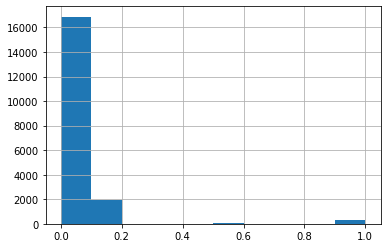

In [65]:
unknown_df['predicted_prob'].hist()

In [66]:
unknown_df

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,label,label_code,type_code,predicted,predicted_prob
0,A,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND,NaN,NaN,248,0.0,0.0
1,A00000,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7,NaN,NaN,431,0.0,0.0
3,A00008,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46,NaN,NaN,350,0.0,0.0
4,A0001E,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X,NaN,NaN,126,0.0,0.0
5,A0002B,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.767405,0.191456,0.023734,0.017405,0.000000,0.150316,0.113924,0.178797,0.534810,0.022152,0.001582,0.009494,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6,2356,632,C82S,NaN,NaN,133,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19794,ADFFFA,0.090909,0.454545,0.000000,0.454545,0.000000,0.000000,0.272727,0.181818,0.363636,0.181818,0.012195,0.008711,0.017422,0.099303,0.862369,0.003484,0.137631,0.203833,0.071429,0.583624,0.054007,0.073171,0.214286,0.322300,0.078397,0.200348,0.008711,0.024390,11,5154,574,unknown,NaN,NaN,454,1.0,1.0
19795,ADFFFC,0.352941,0.323529,0.176471,0.117647,0.029412,0.235294,0.176471,0.264706,0.117647,0.205882,0.020158,0.005259,0.025416,0.095530,0.853637,0.025416,0.122699,0.131464,0.149869,0.570552,0.025416,0.028046,0.232252,0.359334,0.070990,0.199825,0.021911,0.035057,34,0,1141,unknown,NaN,NaN,454,0.0,0.0
19796,ADFFFF,0.192308,0.423077,0.230769,0.115385,0.038462,0.153846,0.153846,0.384615,0.230769,0.076923,0.053785,0.021912,0.016932,0.058765,0.848606,0.046813,0.042829,0.065737,0.121514,0.723108,0.066733,0.071713,0.185259,0.244024,0.062749,0.242032,0.026892,0.041833,26,4000,1004,unknown,NaN,NaN,454,0.0,0.0
19797,AE1899,0.000000,0.200000,0.000000,0.800000,0.000000,0.000000,0.200000,0.200000,0.400000,0.200000,0.624521,0.273946,0.063218,0.015326,0.022989,0.028736,0.000000,0.000000,0.477011,0.494253,0.019157,0.045977,0.231801,0.404215,0.063218,0.201149,0.015326,0.011494,5,5335,522,unknown,NaN,NaN,454,0.0,0.0


### Get the top 200 predictions

Take a look at what the probabilities look like, showing the top 200 planes that are **most likely to be surveillance planes.**

Then save them to a file for later research.

In [67]:
unknown_df.sort_values('predicted_prob',ascending=False).head(200)
#.tail()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,label,label_code,type_code,predicted,predicted_prob
6644,A3F87B,0.456897,0.327586,0.103448,0.086207,0.025862,0.724138,0.215517,0.043103,0.017241,0.000000,0.771810,0.161478,0.046185,0.004790,0.015737,0.940472,0.026685,0.032843,0.000000,0.000000,0.157715,0.091687,0.215532,0.085871,0.043791,0.194321,0.051317,0.067054,116,0,2923,AS55,NaN,NaN,19,1.0,1.0
15656,AAAFDE,0.045455,0.181818,0.181818,0.045455,0.545455,0.045455,0.090909,0.272727,0.090909,0.500000,0.039604,0.053218,0.212252,0.629332,0.065594,0.044554,0.108292,0.230198,0.500619,0.116337,0.030941,0.124381,0.155322,0.344059,0.027847,0.262376,0.025990,0.008663,22,0,1616,SR22,NaN,NaN,406,1.0,1.0
7340,A49539,0.000000,0.000000,0.285714,0.000000,0.714286,0.428571,0.428571,0.142857,0.000000,0.000000,0.842289,0.103978,0.039079,0.014655,0.000000,0.000000,0.023726,0.265178,0.711096,0.000000,0.124215,0.096301,0.130495,0.387299,0.023726,0.122819,0.026518,0.048151,7,4401,1433,AS50,NaN,NaN,18,1.0,1.0
4207,A248EE,0.180952,0.180952,0.161905,0.076190,0.400000,0.352381,0.209524,0.219048,0.057143,0.161905,0.589738,0.268738,0.109684,0.021959,0.009881,0.169046,0.364990,0.245681,0.182660,0.037623,0.115905,0.230457,0.265042,0.229139,0.029278,0.076416,0.008088,0.009735,105,0,27324,C206,NaN,NaN,95,1.0,1.0
8255,A50B32,0.000000,0.000000,0.388889,0.055556,0.555556,0.000000,0.000000,0.000000,0.166667,0.833333,0.002591,0.001943,0.013601,0.095855,0.886010,0.000648,0.006477,0.013601,0.073834,0.905440,0.011658,0.036917,0.222798,0.402202,0.110104,0.190415,0.012306,0.004534,18,3616,1544,C56X,NaN,NaN,126,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,A03916,0.076923,0.153846,0.461538,0.076923,0.230769,0.076923,0.076923,0.461538,0.153846,0.230769,0.043860,0.070175,0.276316,0.596491,0.013158,0.065789,0.146199,0.043860,0.491228,0.252924,0.071637,0.143275,0.115497,0.337719,0.005848,0.235380,0.062865,0.008772,13,0,684,BE35,NaN,NaN,53,1.0,1.0
5634,A35C07,0.375000,0.125000,0.125000,0.125000,0.250000,0.187500,0.312500,0.000000,0.312500,0.187500,0.108411,0.224299,0.433645,0.231776,0.001869,0.000000,0.091589,0.469159,0.439252,0.000000,0.029907,0.046729,0.158879,0.461682,0.080374,0.162617,0.014953,0.022430,16,0,535,BE36,NaN,NaN,54,1.0,1.0
17320,AC0FBC,0.000000,0.000000,0.285714,0.142857,0.571429,0.000000,0.000000,0.000000,0.428571,0.571429,0.023217,0.427861,0.500829,0.048093,0.000000,0.018242,0.044776,0.162521,0.774461,0.000000,0.051410,0.154229,0.049751,0.480929,0.003317,0.210614,0.034826,0.006633,7,0,603,SR20,NaN,NaN,405,1.0,1.0
8363,A51D3F,0.687500,0.250000,0.000000,0.062500,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.776657,0.223343,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.182997,0.118156,0.374640,0.077810,0.051873,0.152738,0.005764,0.002882,16,1200,694,PA11,NaN,NaN,338,1.0,1.0


Save these top 200 to a CSV named `planes-to-research.csv`.

In [68]:
unknown_df.sort_values('predicted_prob',ascending=False).head(200).to_csv('planes-to-research.csv')

# Questions

Using words and not column names, describe what the machine learning algorithm found to be important when identifying surveillance planes.

In [ ]:
# Still trying to understand what the columns actually mean

Why did we use test/train split when it would have been more effective to give our model all of the data from the start?

In [ ]:
# In order to test/evaluate different classifiers

Why did we use a random forest instead of a decision tree or logistic regression?

In [ ]:
# Random Forest? Decision tree seems better.

Why did we use probability instead of just looking for planes with a predicted value of 1? It seems like we should have just trusted the algorithm, right?

In [ ]:
# No, the propability allow us to sort the entries with more nuances

The government could claim that we're threatening national security by publishing this paper as well as publishing this code - now anyone could look for planes that are surveilling them. What do you think?

In [ ]:
# Doesn't make sense. It's just annalysis with data publicaly available in the internet. 

We're using data from the past, but you can get real-time flight data from many services. Can you think of any uses for this algorithm using real-time instead of historical data?

In [ ]:
# To Identify new areas of interest by intel agencies